In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
# Load in the DFT features
xyDFT_pkl= open('./data/BH_CR_DFT.pkl', 'rb')
xyDFT= pickle.load(xyDFT_pkl)
ys=xyDFT['yield'].to_numpy()

# Load in indices by compound number
xNum_pkl= open('./data/BH_CR_numbers.pkl', 'rb')
xNum= pickle.load(xNum_pkl)

In [3]:
# Encode compounds as one hot vectors
from sklearn.preprocessing import OneHotEncoder

cats= [[0,1,2], [0,1,2,3], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
xs= OneHotEncoder(categories=cats, sparse=False).fit_transform(xNum)
print(xs.shape)

(4135, 45)


In [4]:
from numpy.random import RandomState

def getSplit(xNum, testPct, randomSeed=None):
    '''
    Input:
    xNum: contains identities of compounds in each sample (df)
    testPct: split percentage
    randomSeed: random seed

    Output:
    idxTr: array of indices of test samples such that df.take(idxTe) returns training samples
    idxTe: array of indices of test samples such that df.take(idxTe) returns test samples
    additiveTe: additives that were split for the test set
    '''
    u= xNum.additive_number.unique()
    if randomSeed == None:
        rng= RandomState()
    else:
        rng= RandomState(randomSeed)
    additiveTe= rng.choice(u, size= int(u.size * testPct), replace=False)
    idxTe= np.array([], dtype=int)
    for add in np.nditer(additiveTe):
        addIdx= xNum.index[xNum.additive_number == add].to_numpy()
        idxTe= np.concatenate((idxTe, addIdx))
    idxTr= np.delete(np.arange(xNum.index.max()), idxTe)

    return idxTr, idxTe, additiveTe

In [5]:
# Generate splits

# Split off the test data
idxTr, idxTe, testAdditives= getSplit(xNum, testPct=0.2, randomSeed=420)
print('The test set contains additives: %s' % testAdditives)

# The test set (xTe, yTe)
xNumTe= xNum.additive_number.take(idxTe).to_numpy()
xTe= xs.take(idxTe, axis=0)
yTe= ys.take(idxTe, axis=0)

# Generate the training set
xNumTr= xNum.additive_number.take(idxTr).to_numpy()
xTr= xs.take(idxTr, axis=0)
yTr= ys.take(idxTr, axis=0)

print('Size of the splits:')
print('Train: {}'.format(xTr.shape))
print('Test: {}'.format(xTe.shape))

The test set contains additives: [ 5  3  9 23]
Size of the splits:
Train: (3414, 45)
Test: (720, 45)


In [6]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Linear Models

In [16]:
from sklearn.linear_model import LinearRegression

ols= LinearRegression().fit(xTr, yTr)
scaledOLS= make_pipeline(StandardScaler(), LinearRegression()).fit(xTr, yTr)

from sklearn.linear_model import RidgeCV

ridge= RidgeCV(
    alphas= np.logspace(-3,3),
    cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr),
    scoring= make_scorer(mean_squared_error, greater_is_better=False)).fit(xTr, yTr)
scaledridge= make_pipeline(StandardScaler(), RidgeCV(
    alphas= np.logspace(-3,3),
    cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr),
    scoring= make_scorer(mean_squared_error, greater_is_better=False))).fit(xTr, yTr)

from sklearn.linear_model import LassoCV

lasso= LassoCV(cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000).fit(xTr, yTr)
scaledlasso= make_pipeline(StandardScaler(), LassoCV(cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000)).fit(xTr, yTr)

from sklearn.linear_model import ElasticNetCV

enet= ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000).fit(xTr, yTr)
scaledenet= make_pipeline(StandardScaler(), ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000)).fit(xTr, yTr)

The model: OLS
Training MSE: 209.21204
Test MSE: 29991462986394137247350784.00000
Test R2: -36230047773802677403648.00000
The model: scaled OLS
Training MSE: 212.35761
Test MSE: 343334039793679732066981249024.00000
Test R2: -414751646818321034343612416.00000


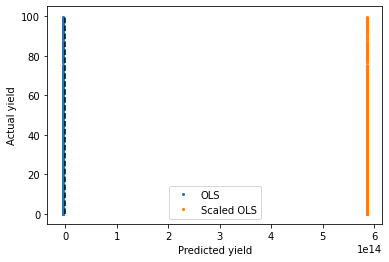

In [17]:
# Evaluate the models
# Evaluate the unscaled ols model
print('The model: OLS')
print("Training MSE: %.5f" % mean_squared_error(yTr, ols.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, ols.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, ols.predict(xTe)))

# Evaluate the scaled ols model
print('The model: scaled OLS')
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledOLS.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledOLS.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledOLS.predict(xTe)))

# Generate exp-actual plot
plt.plot(ols.predict(xTe), yTe, '.', markersize=4, label='OLS')
plt.plot(scaledOLS.predict(xTe), yTe, '.', markersize=4, label='Scaled OLS')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The model: Ridge Regression | alpha: 2.023589647725158
Training MSE: 209.21844
Test MSE: 298.63609
Test R2: 0.63924
The model: Scaled Ridge Regression | alpha: 33.9322177189533
Training MSE: 209.22010
Test MSE: 298.82976
Test R2: 0.63901


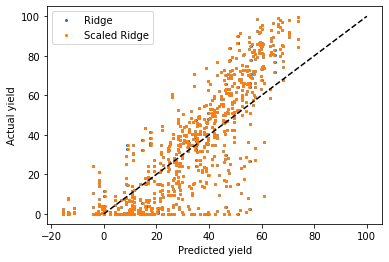

In [18]:
# Evaluate the models
# Evaluate the unscaled ridge regression model
print('The model: Ridge Regression | alpha: %s' % ridge.alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, ridge.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, ridge.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, ridge.predict(xTe)))

# Evaluate the scaled ridge regression model
print('The model: Scaled Ridge Regression | alpha: %s' % scaledridge[1].alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledridge.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledridge.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledridge.predict(xTe)))

# Generate exp-actual plot
plt.plot(ridge.predict(xTe), yTe, '.', markersize=4, label='Ridge')
plt.plot(scaledridge.predict(xTe), yTe, '.', markersize=4, label='Scaled Ridge')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The model: Lasso Regression | alpha: 0.00330
Training MSE: 209.18433
Test MSE: 294.26433
Test R2: 0.64453
The model: Scaled Lasso Regression | alpha: 0.00834
Training MSE: 209.18055
Test MSE: 294.14919
Test R2: 0.64466


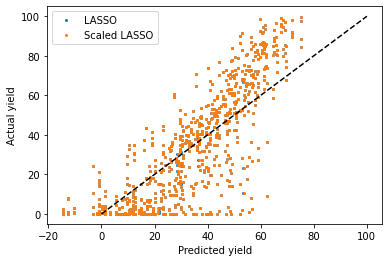

In [19]:

# Evaluate the models
# Evaluate the unscaled lasso regression model
print('The model: Lasso Regression | alpha: %.5f' % lasso.alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, lasso.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, lasso.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, lasso.predict(xTe)))

# Evaluate the scaled lasso regression model
print('The model: Scaled Lasso Regression | alpha: %.5f' % scaledlasso[1].alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledlasso.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledlasso.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledlasso.predict(xTe)))

# Generate exp-actual plot
plt.plot(lasso.predict(xTe), yTe, '.', markersize=4, label='LASSO')
plt.plot(scaledlasso.predict(xTe), yTe, '.', markersize=4, label='Scaled LASSO')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The model: Elastic Net Regression | alpha: 0.00330 | l1 ratio: 1.00000
Training MSE: 209.18433
Test MSE: 294.26433
Test R2: 0.64453
The model: Scaled Elastic Net Regression | alpha: 0.00834 | l1 ratio: 1.00000
Training MSE: 209.18055
Test MSE: 294.14919
Test R2: 0.64466


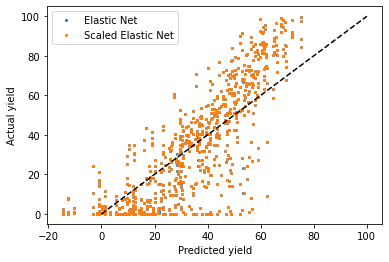

In [20]:
# Evaluate the models
# Evaluate the unscaled elastic net regression model
print('The model: Elastic Net Regression | alpha: %.5f | l1 ratio: %.5f' % (enet.alpha_, enet.l1_ratio_))
print("Training MSE: %.5f" % mean_squared_error(yTr, enet.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, enet.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, enet.predict(xTe)))

# Evaluate the scaled elastic net regression model
print('The model: Scaled Elastic Net Regression | alpha: %.5f | l1 ratio: %.5f' % (scaledenet[1].alpha_, scaledenet[1].l1_ratio_))
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledenet.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledenet.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledenet.predict(xTe)))

# Generate exp-actual plot
plt.plot(enet.predict(xTe), yTe, '.', markersize=4, label='Elastic Net')
plt.plot(scaledenet.predict(xTe), yTe, '.', markersize=4, label='Scaled Elastic Net')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()


In [21]:
from sklearn.linear_model import SGDRegressor

sgdr= GridSearchCV(SGDRegressor(learning_rate='adaptive', early_stopping=True),
    param_grid={'alpha': np.logspace(-3,3,num=7)},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)


Fitting 19 folds for each of 7 candidates, totalling 133 fits


In [22]:
scaledSGDR= make_pipeline(StandardScaler(),
    GridSearchCV(SGDRegressor(learning_rate='adaptive', early_stopping=True),
    param_grid={'alpha': np.logspace(-3,3, num=7), 'penalty': ['l1','l2']},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 14 candidates, totalling 266 fits


The best model: SGDRegressor(alpha=0.001, early_stopping=True, learning_rate='adaptive')
Training MSE: 209.47077
Test MSE: 302.98369
Test R2: 0.63399
The best model: SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='adaptive',
             penalty='l1')
Training MSE: 209.91206
Test MSE: 295.77603
Test R2: 0.64270


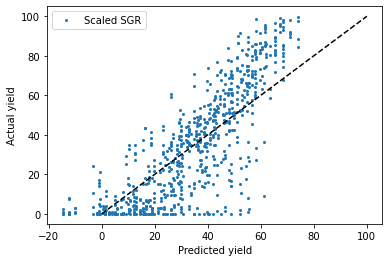

In [23]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % sgdr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, sgdr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, sgdr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, sgdr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSGDR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSGDR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSGDR.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledSGDR.predict(xTe)))

# Generate exp-actual plot
# plt.plot(sgdr.predict(xTe), yTe, '.', markersize=4, label='KNR')
plt.plot(scaledSGDR.predict(xTe), yTe, '.', markersize=4, label='Scaled SGR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Generalized Linear Models

In [24]:
from sklearn.linear_model import TweedieRegressor

glm= GridSearchCV(TweedieRegressor(max_iter=1000), 
    param_grid={"power": [0, 1, 1.5, 2, 3]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

# Scale the data before fitting the data
scaledGLM= make_pipeline(StandardScaler(),
    GridSearchCV(TweedieRegressor(max_iter=1000),
    param_grid={"power": [0, 1, 1.5, 2, 3], 'alpha': np.linspace(0,1, num=6)},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

glmAMZ= make_pipeline(StandardScaler(), TweedieRegressor(power= 0, alpha= 0.1)).fit(xTr, yTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
38 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
38 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py", line 263, in fit
    raise ValueError(
ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

  warnings.warn(some_fits_failed_message, Fi

Fitting 19 folds for each of 30 candidates, totalling 570 fits


/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
228 fits failed out of a total of 570.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
228 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py", line 263, in fit
    raise ValueError(
ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

  warnings.warn(some_fits_failed_message,

The best model: TweedieRegressor(max_iter=1000, power=1)
Training MSE: 221.55470
Test MSE: 348.62210
Test R2: 0.57886
The best model: TweedieRegressor(alpha=0.2, max_iter=1000, power=1)
Training MSE: 161.49862
Test MSE: 281.86439
Test R2: 0.65950
The Zuranski model: TweedieRegressor(alpha=0.1, power=0)
Training MSE: 212.80834
Test MSE: 311.32997
Test RMSE: 17.64454
Test R2: 0.62391


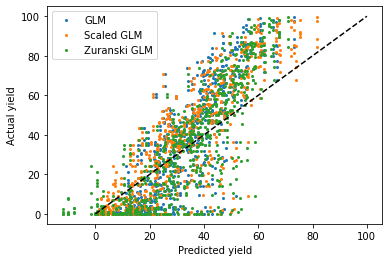

In [25]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % glm.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, glm.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, glm.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, glm.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledGLM[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledGLM.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledGLM.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledGLM.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % glmAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, glmAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, glmAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, glmAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, glmAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(glm.predict(xTe), yTe, '.', markersize=4, label='GLM')
plt.plot(scaledGLM.predict(xTe), yTe, '.', markersize=4, label='Scaled GLM')
plt.plot(glmAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski GLM')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### k-Neighbors Regression

In [26]:
from sklearn.neighbors import KNeighborsRegressor

knr= GridSearchCV(KNeighborsRegressor(weights='distance'), 
    param_grid={"n_neighbors": [1,3,5], "p": [1,2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

# Scale the data before fitting the data
scaledKNR= make_pipeline(StandardScaler(),
    GridSearchCV(KNeighborsRegressor(weights='distance'), 
    param_grid={"n_neighbors": [1,3,5], "p": [1,2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 6 candidates, totalling 114 fits
Fitting 19 folds for each of 6 candidates, totalling 114 fits


In [27]:
# Scale the data before fitting the data
scaledKNR2= make_pipeline(StandardScaler(),
    GridSearchCV(KNeighborsRegressor(weights='distance'), 
    param_grid={"n_neighbors": [5, 10, 50, 100], "p": [1,2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 8 candidates, totalling 152 fits


In [28]:
# Zuranski Model
knrAMZ=make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors= 3)).fit(xTr, yTr)

The best model: KNeighborsRegressor(weights='distance')
Training MSE: 0.00000
Test MSE: 247.61289
Test R2: 0.70088
The best model: KNeighborsRegressor(weights='distance')
Training MSE: 0.00000
Test MSE: 231.29720
Test RMSE: 15.20846
Test R2: 0.72059


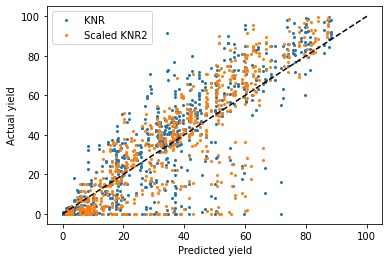

In [29]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % knr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, knr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, knr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, knr.predict(xTe)))

print('The best model: %s' % scaledKNR2[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledKNR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledKNR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledKNR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledKNR2.predict(xTe)))

# Generate exp-actual plot
plt.plot(knr.predict(xTe), yTe, '.', markersize=4, label='KNR')
plt.plot(scaledKNR2.predict(xTe), yTe, '.', markersize=4, label='Scaled KNR2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The best model: KNeighborsRegressor(weights='distance')
Training MSE: 0.00000
Test MSE: 231.29720
Test RMSE: 15.20846
Test R2: 0.72059
The Zuranski model: KNeighborsRegressor(n_neighbors=3)
Training MSE: 129.07411
Test MSE: 239.71724
Test RMSE: 15.48280
Test R2: 0.71042


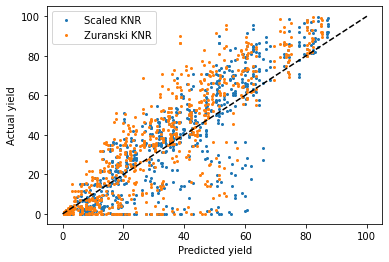

In [30]:
# Evaluate the scaled model
print('The best model: %s' % scaledKNR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledKNR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledKNR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledKNR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledKNR.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % knrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, knrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, knrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, knrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, knrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(scaledKNR.predict(xTe), yTe, '.', markersize=4, label='Scaled KNR')
plt.plot(knrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski KNR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Gaussian Process Regression

## Something wrong here

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct, ExpSineSquared

gp= GaussianProcessRegressor(random_state=0).fit(xTr, yTr)
gpr= GridSearchCV(gp, 
    param_grid={"kernel": [RBF, RationalQuadratic, DotProduct, ExpSineSquared]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1,
    error_score='raise').fit(xTr, yTr, groups=xNumTr)
    
scaledGPR= make_pipeline(StandardScaler(),
    GridSearchCV(GaussianProcessRegressor(), 
    param_grid={"kernel": [RBF, RationalQuadratic, DotProduct, ExpSineSquared]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

The best model: GaussianProcessRegressor(random_state=0)
Training MSE: 0.00000
Test MSE: 2086.59167
Test R2: -1.52063
The best model: GaussianProcessRegressor()
Training MSE: 0.00000
Test MSE: 1468.07639
Test R2: -0.77345


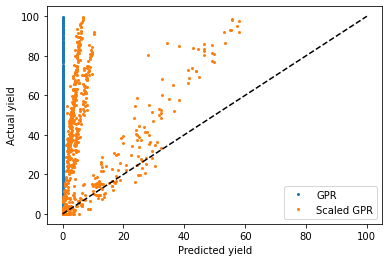

In [105]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % gp)
print("Training MSE: %.5f" % mean_squared_error(yTr, gp.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, gp.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, gp.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledGPR[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledGPR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledGPR.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledGPR.predict(xTe)))

# Generate exp-actual plot
plt.plot(gpr.predict(xTe), yTe, '.', markersize=4, label='GPR')
plt.plot(scaledGPR.predict(xTe), yTe, '.', markersize=4, label='Scaled GPR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

#### Support Vector Regression

In [32]:
from sklearn.svm import SVR

svr = GridSearchCV(SVR(),
    param_grid={"C": [1e-1, 1e0, 1e1, 1e2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 4 candidates, totalling 76 fits


In [33]:
scaledSVR= make_pipeline(StandardScaler(),
    GridSearchCV(SVR(),
    param_grid={"C": [1e-2, 1e0, 1e2], 'kernel': ['linear', 'rbf', 'sigmoid']},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 9 candidates, totalling 171 fits


In [35]:
print('The best model: %s' % scaledSVR[1].best_estimator_)

The best model: SVR(C=100.0)


In [36]:
scaledSVR2= make_pipeline(StandardScaler(),
    GridSearchCV(SVR(C=100),
    param_grid={"gamma": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


In [34]:
# Zuranski model
svrAMZ= make_pipeline(StandardScaler(),SVR(C=0.5, gamma=0.007)).fit(xTr, yTr)

The best model: SVR(C=100.0)
Training MSE: 15.77776
Test MSE: 213.01348
Test R2: 0.74268
The best model: SVR(C=100.0)
Training MSE: 22.23475
Test MSE: 232.80521
Test RMSE: 15.25796
Test R2: 0.71877
The best model: SVR(C=100, gamma=0.01)
Training MSE: 62.24733
Test MSE: 201.53018
Test RMSE: 14.19613
Test R2: 0.75655
The Zuranski model: SVR(C=0.5, gamma=0.007)
Training MSE: 397.64864
Test MSE: 509.86318
Test RMSE: 22.58015
Test R2: 0.38408


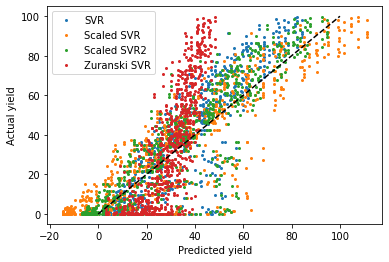

In [37]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % svr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, svr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, svr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, svr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSVR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSVR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSVR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledSVR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledSVR.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSVR2[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSVR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSVR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledSVR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledSVR2.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % svrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, svrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, svrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, svrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, svrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(svr.predict(xTe), yTe, '.', markersize=4, label='SVR')
plt.plot(scaledSVR.predict(xTe), yTe, '.', markersize=4, label='Scaled SVR')
plt.plot(scaledSVR2.predict(xTe), yTe, '.', markersize=4, label='Scaled SVR2')
plt.plot(svrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski SVR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Tree Based Methods

#### Regression Tree

In [38]:
from sklearn.tree import DecisionTreeRegressor

dtr= GridSearchCV(DecisionTreeRegressor(),
    param_grid={"min_samples_leaf": [1, 10, 100, 200, 300, 400, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

scaledDTR= make_pipeline(StandardScaler(), 
    GridSearchCV(DecisionTreeRegressor(),
    param_grid={"min_samples_leaf": [1, 10, 100, 200, 300, 400, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)


Fitting 19 folds for each of 7 candidates, totalling 133 fits
Fitting 19 folds for each of 7 candidates, totalling 133 fits


The best model: DecisionTreeRegressor(min_samples_leaf=10)
Training MSE: 126.32956
Test MSE: 254.39371
Test R2: 0.69269
The best model: DecisionTreeRegressor(min_samples_leaf=10)
Training MSE: 126.32956
Test MSE: 254.39371
Test RMSE: 15.94972
Test R2: 0.69269


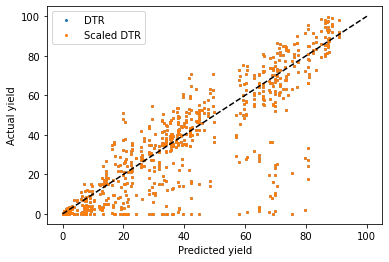

In [39]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % dtr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, dtr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, dtr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, dtr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledDTR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledDTR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledDTR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledDTR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledDTR.predict(xTe)))

# Generate exp-actual plot
plt.plot(dtr.predict(xTe), yTe, '.', markersize=4, label='DTR')
plt.plot(scaledDTR.predict(xTe), yTe, '.', markersize=4, label='Scaled DTR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()


In [8]:
from sklearn.ensemble import RandomForestRegressor


In [13]:
rfr= GridSearchCV(RandomForestRegressor(max_features='sqrt'),
    param_grid={"n_estimators": [10, 100, 300, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)


Fitting 19 folds for each of 4 candidates, totalling 76 fits


In [41]:
scaledRFR= make_pipeline(StandardScaler(), 
    GridSearchCV(RandomForestRegressor(max_features='sqrt'),
    param_grid={"n_estimators": [10, 100, 300, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)


Fitting 19 folds for each of 4 candidates, totalling 76 fits


In [11]:
scaledRFR= make_pipeline(StandardScaler(), 
    GridSearchCV(RandomForestRegressor(max_features='log2'),
    param_grid={"n_estimators": [10, 20, 30, 40, 50]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


In [10]:
scaledRFR2= make_pipeline(StandardScaler(), 
    GridSearchCV(RandomForestRegressor(max_features='sqrt'),
    param_grid={"n_estimators": [10, 20, 30, 40, 50]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


In [9]:
# Zuranski Model
rfrAMZ= make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=20)).fit(xTr, yTr)

The best model: RandomForestRegressor(max_features='sqrt', n_estimators=300)
Training MSE: 14.34820
Test MSE: 207.02243
Test RMSE: 14.38827
Test R2: 0.74991
The best model: RandomForestRegressor(max_features='log2', n_estimators=50)
Training MSE: 17.62968
Test MSE: 206.52309
Test RMSE: 14.37091
Test R2: 0.75052
The best model: RandomForestRegressor(max_features='sqrt', n_estimators=50)
Training MSE: 15.99959
Test MSE: 206.44539
Test RMSE: 14.36821
Test R2: 0.75061
The Zuranski model: RandomForestRegressor(n_estimators=20)
Training MSE: 11.81859
Test MSE: 279.85589
Test RMSE: 16.72889
Test R2: 0.66193


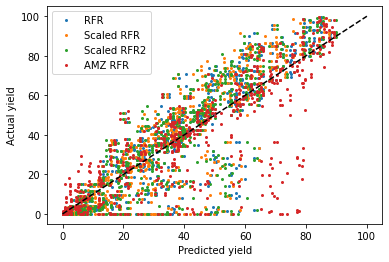

In [15]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % rfr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, rfr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, rfr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, rfr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, rfr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledRFR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledRFR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledRFR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledRFR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledRFR.predict(xTe)))

# Evaluate the scaled model2
print('The best model: %s' % scaledRFR2[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledRFR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledRFR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledRFR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledRFR2.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % rfrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, rfrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, rfrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, rfrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, rfrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(rfr.predict(xTe), yTe, '.', markersize=4, label='RFR')
plt.plot(scaledRFR.predict(xTe), yTe, '.', markersize=4, label='Scaled RFR')
plt.plot(scaledRFR2.predict(xTe), yTe, '.', markersize=4, label='Scaled RFR2')
plt.plot(rfrAMZ.predict(xTe), yTe, '.', markersize=4, label='AMZ RFR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbr= GridSearchCV(GradientBoostingRegressor(n_estimators=100),
    param_grid={'learning_rate': np.logspace(-2,1, num=4)},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 4 candidates, totalling 76 fits


/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:978: RuntimeWarning: overflow encountered in square
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


In [47]:
print('The best model: %s' % gbr.best_estimator_)

The best model: GradientBoostingRegressor(learning_rate=1.0)


In [48]:
gbr2= GridSearchCV(GradientBoostingRegressor(learning_rate=1),
    param_grid={"n_estimators": [100, 200, 500, 700]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 4 candidates, totalling 76 fits


The best model: GradientBoostingRegressor(learning_rate=1.0)
Training MSE: 56.27197
Test MSE: 245.46122
Test RMSE: 15.66720
Test R2: 0.70348
The best model: GradientBoostingRegressor(learning_rate=1, n_estimators=700)
Training MSE: 18.61288
Test MSE: 245.11115
Test RMSE: 15.65603
Test R2: 0.70390


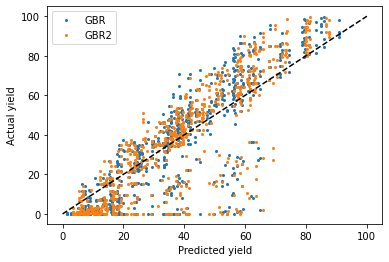

In [49]:
# Evaluate the model
print('The best model: %s' % gbr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, gbr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, gbr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, gbr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, gbr.predict(xTe)))

# Evaluate the model
print('The best model: %s' % gbr2.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, gbr2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, gbr2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, gbr2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, gbr2.predict(xTe)))

# Generate exp-actual plot
plt.plot(gbr.predict(xTe), yTe, '.', markersize=4, label='GBR')
plt.plot(gbr2.predict(xTe), yTe, '.', markersize=4, label='GBR2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [50]:
from sklearn.ensemble import AdaBoostRegressor

abr= GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), loss='exponential'),
    param_grid={"n_estimators": [10, 50, 100], 'learning_rate': [0.1, 1, 10]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 9 candidates, totalling 171 fits


In [51]:
print('The best model: %s' % abr.best_estimator_)

The best model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, loss='exponential')


In [52]:
abr2= GridSearchCV(AdaBoostRegressor(n_estimators=50, learning_rate=0.1, loss='exponential'),
    param_grid={"base_estimator": [DecisionTreeRegressor(max_depth=1), 
        DecisionTreeRegressor(max_depth=2), 
        DecisionTreeRegressor(max_depth=3),
        DecisionTreeRegressor(max_depth=4),
        DecisionTreeRegressor(max_depth=5)]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


The best model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, loss='exponential')
Training MSE: 488.14621
Test MSE: 546.23139
Test RMSE: 23.37159
Test R2: 0.34015
The best model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  learning_rate=0.1, loss='exponential')
Training MSE: 349.56459
Test MSE: 392.58003
Test RMSE: 19.81363
Test R2: 0.52576


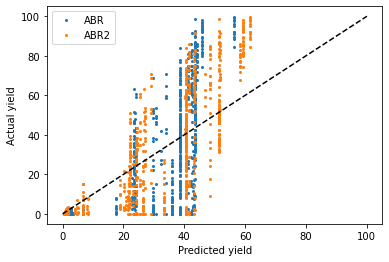

In [53]:
# Evaluate the model
print('The best model: %s' % abr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, abr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, abr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, abr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, abr.predict(xTe)))

# Evaluate the model
print('The best model: %s' % abr2.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, abr2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, abr2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, abr2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, abr2.predict(xTe)))

# Generate exp-actual plot
plt.plot(abr.predict(xTe), yTe, '.', markersize=4, label='ABR')
plt.plot(abr2.predict(xTe), yTe, '.', markersize=4, label='ABR2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [54]:
import xgboost as xgb

xgr= GridSearchCV(xgb.XGBRegressor(eval_metric= mean_squared_error),
    param_grid={"n_estimators": [20, 30, 40], 'max_depth': [3,6,9]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)


Fitting 19 folds for each of 9 candidates, totalling 171 fits


In [58]:
es= xgb.callback.EarlyStopping(
    rounds=20,
    save_best=True,
    maximize=False,
)
xgr2= xgb.XGBRegressor(max_depth=6, n_estimators= 40, learning_rate=0.3).fit(xTr, yTr, eval_set=[(xTe, yTe)], callbacks=[es])

[0]	validation_0-rmse:35.27470
[1]	validation_0-rmse:28.93880
[2]	validation_0-rmse:24.22683
[3]	validation_0-rmse:21.54515
[4]	validation_0-rmse:20.02821
[5]	validation_0-rmse:18.72060
[6]	validation_0-rmse:18.53836
[7]	validation_0-rmse:17.68755
[8]	validation_0-rmse:17.13623
[9]	validation_0-rmse:16.62319
[10]	validation_0-rmse:16.58338
[11]	validation_0-rmse:16.28900
[12]	validation_0-rmse:16.29341
[13]	validation_0-rmse:15.91595
[14]	validation_0-rmse:15.93111
[15]	validation_0-rmse:15.69407
[16]	validation_0-rmse:15.71336
[17]	validation_0-rmse:15.55292
[18]	validation_0-rmse:15.48366
[19]	validation_0-rmse:15.30975
[20]	validation_0-rmse:15.25927
[21]	validation_0-rmse:15.20549
[22]	validation_0-rmse:15.17189
[23]	validation_0-rmse:15.13858
[24]	validation_0-rmse:15.09999
[25]	validation_0-rmse:15.09606
[26]	validation_0-rmse:15.03469
[27]	validation_0-rmse:15.02683
[28]	validation_0-rmse:15.03089
[29]	validation_0-rmse:15.00963
[30]	validation_0-rmse:14.96617
[31]	validation_0-

In [220]:
xgr4= GridSearchCV(xgb.XGBRegressor(max_depth=3, n_estimators= 30, learning_rate=0.3),
    param_grid={'subsample': [0.2, 0.4, 0.6, 0.8, 1]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


In [55]:
# Zuranski Model
xgrAMZ= xgb.XGBRegressor(max_depth=6, n_estimators= 15, learning_rate= 0.3, gamma=0, subsample=1).fit(xTr, yTr)

The best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7f8243843430>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=40, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Training MSE: 50.06756
Test MSE: 219.38095
Test RMSE: 14.81151
Test R2: 0.73499
The best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, import

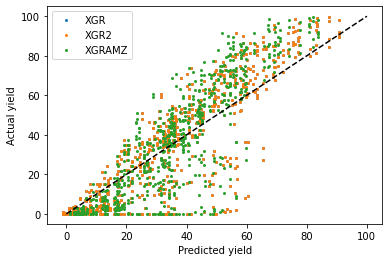

In [59]:
# Evaluate the model
print('The best model: %s' % xgr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgr.predict(xTe)))

# Evaluate the model
print('The best model: %s' % xgr2)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgr2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgr2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgr2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgr2.predict(xTe)))

# # Evaluate the model
# print('The best model: %s' % xgr4.best_estimator_)
# print("Training MSE: %.5f" % mean_squared_error(yTr, xgr4.predict(xTr)))
# print("Test MSE: %.5f" % mean_squared_error(yTe, xgr4.predict(xTe)))
# print("Test RMSE: %.5f" % mean_squared_error(yTe, xgr4.predict(xTe), squared=False))
# print('Test R2: %.5f' % r2_score(yTe, xgr4.predict(xTe)))

# Evaluate the model
print('The Zuranski model: %s' % xgrAMZ)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(xgr.predict(xTe), yTe, '.', markersize=4, label='XGR')
plt.plot(xgr2.predict(xTe), yTe, '.', markersize=4, label='XGR2')
# plt.plot(xgr3.predict(xTe), yTe, '.', markersize=4, label='XGR3')
plt.plot(xgrAMZ.predict(xTe), yTe, '.', markersize=4, label='XGRAMZ')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Neural Nets

In [16]:
from sklearn.neural_network import MLPRegressor


In [ ]:

nnr= GridSearchCV(MLPRegressor(),
    param_grid={"hidden_layer_sizes": [(1), (5,), (10,), (100,)], "alpha": [1e-5, 1e-4, 1e-3]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

In [ ]:
scaledNNR= make_pipeline(StandardScaler(),
    GridSearchCV(MLPRegressor(),
    param_grid={"hidden_layer_sizes": [(3,), (4,), (5,), (6,), (8,), (10,)]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

In [17]:
scaledNNR2= make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(6,), max_iter=10000)).fit(xTr, yTr)

In [18]:
nnrAMZ= make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(4,), max_iter=10000)).fit(xTr, yTr)

The best model: MLPRegressor(hidden_layer_sizes=(6,), max_iter=10000)
Training MSE: 85.80536
Test MSE: 205.36660
Test RMSE: 14.33062
Test R2: 0.75191
The Zuranski model: MLPRegressor(hidden_layer_sizes=(4,), max_iter=10000)
Training MSE: 98.90364
Test MSE: 218.40148
Test RMSE: 14.77841
Test R2: 0.73617


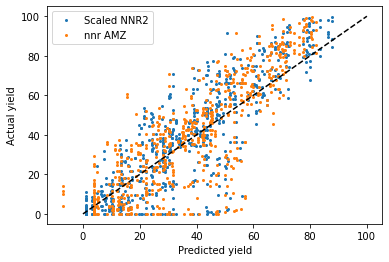

In [19]:
# Evaluate the model
# print('The best model: %s' % nnr.best_estimator_)
# print("Training MSE: %.5f" % mean_squared_error(yTr, nnr.predict(xTr)))
# print("Test MSE: %.5f" % mean_squared_error(yTe, nnr.predict(xTe)))
# print("Test RMSE: %.5f" % mean_squared_error(yTe, nnr.predict(xTe), squared=False))
# print('Test R2: %.5f' % r2_score(yTe, nnr.predict(xTe)))

# # Evaluate the model
# print('The best model: %s' % scaledNNR[1].best_estimator_)
# print("Training MSE: %.5f" % mean_squared_error(yTr, scaledNNR.predict(xTr)))
# print("Test MSE: %.5f" % mean_squared_error(yTe, scaledNNR.predict(xTe)))
# print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledNNR.predict(xTe), squared=False))
# print('Test R2: %.5f' % r2_score(yTe, scaledNNR.predict(xTe)))

# Evaluate the model
print('The best model: %s' % scaledNNR2[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledNNR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledNNR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledNNR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledNNR2.predict(xTe)))

# Evaluate the model
print('The Zuranski model: %s' % nnrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, nnrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, nnrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, nnrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, nnrAMZ.predict(xTe)))

# Generate exp-actual plot
# plt.plot(nnr.predict(xTe), yTe, '.', markersize=4, label='NNR')
# plt.plot(scaledNNR.predict(xTe), yTe, '.', markersize=4, label='Scaled NNR')
plt.plot(scaledNNR2.predict(xTe), yTe, '.', markersize=4, label='Scaled NNR2')
plt.plot(nnrAMZ.predict(xTe), yTe, '.', markersize=4, label='nnr AMZ')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()